# Chapter 7. Fine-tuning to follow instructions

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
torch.version.cuda

'12.6'

## 7.2. Preparing the dataset for supervised instruction fine-tuning

In [3]:
# Listing 7.1. Download the dataset
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


**Exercise 7.1. Changing prompt styles**

After fine-tuning the model with the Alpaca prompt style, try the Phi-3 prompt style shown in figure 7.4 and observe whether it affects the response quality of the model.

In [6]:
def format_input(entry):
    instruction_text = (
        f"<|user|>\n{entry['instruction']}"
    )

    input_text = f"\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
# Listing 7.2. Implementing the prompt formatting function

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [8]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [9]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [10]:
# Listing 7.3. Partitioning the dataset
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3. Organizing data into training batches

In [11]:
# Listing 7.4. Implementing an instruction dataset class
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [13]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_1st.append(inputs)

    inputs_tensor = torch.stack(inputs_1st).to(device)
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [15]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_1st, targets_1st = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_1st.append(inputs)
        targets_1st.append(targets)

    inputs_tensor = torch.stack(inputs_1st).to(device)
    targets_tensor = torch.stack(targets_1st).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [16]:
# Listing 7.5. Implementing a custom batch collate function
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [20]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


**Exercise 7.2. Instruction and input masking**

After completing the chapter and fine-tuning the model with *InstructionDataset*, replace the instruction and input tokens with the *-100* mask to use the instruction masking method illustrated in figure 7.13. Then evaluate whether this has a positive effect on model performance.

In [21]:
class InstructionDatasetInputMasking(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        ##########################################################################################
        # New: Separate list for instruction lengths
        self.instruction_lengths = []
        ##########################################################################################
        
        self.encoded_texts = []
        
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

            ##########################################################################################
            # New: collect instruction lengths
            instruction_length = len(tokenizer.encode(instruction_plus_input))
            self.instruction_lengths.append(instruction_length)
            ##########################################################################################
            
    def __getitem__(self, index):
        # New: return both instruction lengths and texts separately
        return self.instruction_lengths[index], self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [22]:
def custom_collate_input_masking_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for instruction_length, item in batch)   # New: batch is now a tuple

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for instruction_length, item in batch:  # New: batch is now a tuple
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        ##########################################################################################
        # New: Mask all input and instruction tokens in the targets
        targets[:instruction_length-1] = -100
        ##########################################################################################
        
        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

## 7.4. Creating data loaders for an instruction dataset

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Device:", device)

Device: cpu


In [23]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [24]:
# Listing 7.6. Initializing the data loaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

## 7.5. Loading a pretrained LLM

In [39]:
# Listing 7.7. Loading the pretrained model
from gpt_download import download_and_load_gpt2
from chapter4 import GPTModel
from chapter5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [40]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [35]:
from chapter5 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)
generated_text = token_ids_to_text(token_ids, tokenizer)

RuntimeError: Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)

In [42]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6. Fine-tuning the LLM on Instruction data

In [49]:
import chapter5
import importlib
importlib.reload(chapter5)

<module 'chapter5' from '/home/roger/Projectes/build-a-llm-from-scratch/chapter-7/chapter5.py'>

In [32]:
from chapter5 import (
    calc_loss_loader,
    train_model_simple
)

In [45]:
#device = "cuda"
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)

Training loss: 3.8258957386016847
Validation loss: 3.7619208812713625


In [65]:
device

device(type='cuda')

In [47]:
# Listing 7.8. Instruction fine-tuning the pretrained LLM
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=5e-5, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device=device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.798, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

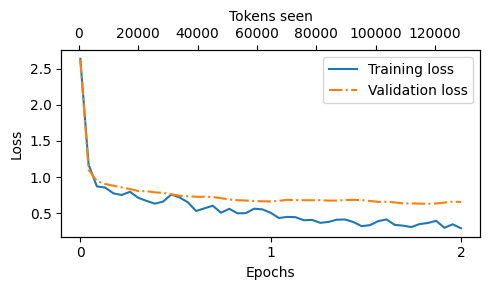

In [50]:
from chapter5 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

**Exercise 7.3. Fine-tuning on the original Alpaca dataset**

The Alpaca dataset, by researchers at Stanford, is one of the earliest and most popular openly shared instruction datasets, consisting of 52,002 entries. As an alternative to the *instruction-data.json* file we use here, consider fine-tuning an LLM on this dataset. The dataset is available at https://mng.bz/NBnE.

This dataset contains 52,002 entries, which is approximately 50 times more than those we used here, and most entries are longer. Thus, I highly recommend using a GPU to conduct the training, which will accelerate the fine-tuning process. If you encounter out-of-memory errors, consider reducing the *batch_size* from 8 to 4, 2, or even 1. Lowering the *allowed_max_length* from 1,024 to 512 or 256 can also help manage memory problems.

In [21]:
alpaca_file_path = "alpaca_data.json"
alpaca_url = "https://mng.bz/NBnE"
alpaca_data = download_and_load_file(alpaca_file_path, alpaca_url)

In [22]:
train_portion = int(len(alpaca_data) * 0.85)
test_portion = int(len(alpaca_data) * 0.1)
val_portion = len(alpaca_data) - train_portion - test_portion

train_data = alpaca_data[:train_portion]
test_data = alpaca_data[train_portion:train_portion + test_portion]
val_data = alpaca_data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 44201
Validation set length: 2601
Test set length: 5200


In [25]:
num_workers = 0
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=256
)

alpaca_train_dataset = InstructionDataset(train_data, tokenizer)
alpaca_train_loader = DataLoader(
    alpaca_train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

alpaca_val_dataset = InstructionDataset(val_data, tokenizer)
alpaca_val_loader = DataLoader(
    alpaca_val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

alpaca_test_dataset = InstructionDataset(test_data, tokenizer)
alpaca_test_loader = DataLoader(
    alpaca_test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [29]:
from gpt_download import download_and_load_gpt2
from chapter4 import GPTModel
from chapter5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}
CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()
model.to(device);

2025-09-01 18:54:23.473217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [33]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=5e-5, weight_decay=0.1
)
num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, alpaca_train_loader, alpaca_val_loader, optimizer, device=device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.250, Val loss 3.279
Ep 1 (Step 000005): Train loss 1.987, Val loss 1.818
Ep 1 (Step 000010): Train loss 1.019, Val loss 1.372
Ep 1 (Step 000015): Train loss 1.320, Val loss 1.285
Ep 1 (Step 000020): Train loss 0.794, Val loss 1.220
Ep 1 (Step 000025): Train loss 0.878, Val loss 1.163
Ep 1 (Step 000030): Train loss 0.978, Val loss 1.136
Ep 1 (Step 000035): Train loss 1.111, Val loss 1.125
Ep 1 (Step 000040): Train loss 1.157, Val loss 1.076
Ep 1 (Step 000045): Train loss 0.751, Val loss 1.048
Ep 1 (Step 000050): Train loss 1.157, Val loss 1.020
Ep 1 (Step 000055): Train loss 1.190, Val loss 1.013
Ep 1 (Step 000060): Train loss 1.122, Val loss 1.035
Ep 1 (Step 000065): Train loss 0.934, Val loss 1.035
Ep 1 (Step 000070): Train loss 0.625, Val loss 1.044
Ep 1 (Step 000075): Train loss 0.685, Val loss 1.042
Ep 1 (Step 000080): Train loss 0.910, Val loss 1.053
Ep 1 (Step 000085): Train loss 0.699, Val loss 1.076
Ep 1 (Step 000090): Train loss 0.859, Val loss

## 7.7. Extracting and saving responses

In [36]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-----------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-----------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a tropical storm.
-----------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice

In [38]:
# Listing 7.9. Generating test set responses
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [03:33<00:00,  1.94s/it]


In [39]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [40]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth


## 7.8. Evaluating the fine-tuned LLM

In [44]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
    )
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [45]:
import urllib.request

def query_model(
    prompt,
    model="gemma3",
    url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )

    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [46]:
model = "gemma3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are surprisingly adaptable eaters! Here's a breakdown of what they typically eat:

**1. Primarily Grasses:** This is the foundation of their diet. They'll happily munch on a wide variety of grasses, including:

*   **Timothy Hay:** This is considered a staple for llamas and is a good source of fiber.
*   **Orchard Grass:** Another popular choice, rich in nutrients.
*   **Brome Grass:** A common and nutritious option.
*   **Fescue:** Can be fed in moderation, as some types can cause health issues.
*   **Various Wild Grasses:** Llamas are often found grazing on native grasses in their natural habitats.


**2. Browse (Leaves, Twigs, and Branches):** Llamas are natural browsers and will supplement their grass diet with:

*   **Tree Branches:** They'll happily nibble on branches from shrubs and trees.
*   **Leaves:**  They'll eat leaves from bushes and trees.
*   **Twigs:**  They enjoy chewing on twigs.

**3. Supplements (Especially Important for Pet Llamas):**

*   **Commercial Llam

In [47]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry['model_response'])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n--------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> Okay, here's the rewritten sentence using a simile:

**The car is as fast as a bullet.**

**Score: 90/100**

**Justification for the score:**

*   **Accuracy:** The response perfectly fulfills the instruction to rewrite the sentence using a simile.
*   **Effectiveness of the Simile:** "As fast as a bullet" is a very strong and commonly used simile for speed, effectively conveying the car's rapid movement. It’s a classic and well-understood comparison.
*   **Minor Deduction (10/100):** While excellent, "The car is as fast as lightning" is arguably a slightly *more* evocative and frequently used simile for speed.  However, "as fast as a bullet" is still a very strong and appropriate choice, so a slight deduction is warranted for not choosing the absolute top-tier simile.

I believe this response demonstrates a strong understanding of the task and provides a well-executed 

In [48]:
# Listing 7.11. Evaluating the instruction fine-tuning LLM
def generate_model_scores(json_data, json_key, model="gemma3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores

In [49]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  40%|████████████████████████████████▍                                                | 44/110 [02:56<05:36,  5.10s/it]

Could not convert score: Laughed.

80



Scoring entries:  44%|███████████████████████████████████▎                                             | 48/110 [03:10<04:12,  4.07s/it]

Could not convert score: Exclamation.

80



Scoring entries:  95%|████████████████████████████████████████████████████████████████████████████▎   | 105/110 [08:05<00:55, 11.17s/it]

Could not convert score: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34.


Scoring entries: 100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [08:25<00:00,  4.60s/it]

Number of scores: 107 of 110
Average score: 58.13



**Exercise 7.4. Parameter-efficient fine-tuning with LoRA**

To instruction fine-tune an LLM more efficiently, modify the code in this chapter to use the low-rank adaptation method (LoRA) from appendix E. Compare the training run time and model performance before and after the modification.